In [1]:
import pandas as pd
import numpy as np

# 2013年keggle人脸识别竞赛数据集
df = pd.read_csv('./data/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


0 anger 生气； 1 disgust 厌恶； 2 fear 恐惧； 3 happy 开心； 4 sad 伤心；5 surprised 惊讶； 6 normal 中性

In [2]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

# INTERESTED_LABELS = [3, 4]
INTERESTED_LABELS = [1, 3, 4, 5, 6]
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(25813, 3)

In [3]:
# 把df.pixels的字符串数据转化为数组(48, 48, 1) 1表示1个通道（灰度）
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48,48,1).astype('float'))
img_array

3        [[[24.0], [32.0], [36.0], [30.0], [32.0], [23....
4        [[[4.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...
6        [[[20.0], [17.0], [19.0], [21.0], [25.0], [38....
7        [[[77.0], [78.0], [79.0], [79.0], [78.0], [75....
8        [[[85.0], [84.0], [90.0], [121.0], [101.0], [1...
                               ...                        
35877    [[[139.0], [143.0], [145.0], [154.0], [159.0],...
35878    [[[0.0], [39.0], [81.0], [80.0], [104.0], [97....
35882    [[[50.0], [36.0], [17.0], [22.0], [23.0], [29....
35883    [[[178.0], [174.0], [172.0], [173.0], [181.0],...
35885    [[[30.0], [28.0], [28.0], [29.0], [31.0], [30....
Name: pixels, Length: 25813, dtype: object

In [4]:
# 换成4维(N, 48, 48, 1) N为图片的数量
img_array = np.stack(img_array, axis=0)
img_array /= 255
img_array

array([[[[0.09411765],
         [0.1254902 ],
         [0.14117647],
         ...,
         [0.67843137],
         [0.6745098 ],
         [0.67843137]],

        [[0.09803922],
         [0.13333333],
         [0.11372549],
         ...,
         [0.67843137],
         [0.6745098 ],
         [0.67843137]],

        [[0.10196078],
         [0.11372549],
         [0.09803922],
         ...,
         [0.6745098 ],
         [0.6745098 ],
         [0.68235294]],

        ...,

        [[0.62352941],
         [0.7254902 ],
         [0.61568627],
         ...,
         [0.61568627],
         [0.61176471],
         [0.6       ]],

        [[0.53333333],
         [0.61568627],
         [0.73333333],
         ...,
         [0.59607843],
         [0.59607843],
         [0.58823529]],

        [[0.56862745],
         [0.50980392],
         [0.63137255],
         ...,
         [0.55686275],
         [0.56078431],
         [0.55686275]]],


       [[[0.01568627],
         [0.        ],
         [0.  

In [5]:
# 假设 inputs 是你的原始输入数据，维度为 [batch_size, height, width, channels]
# 首先转换为 PyTorch 期望的 NCHW 格式
import torch as t

img_array = t.from_numpy(img_array).float()
img_array = img_array.permute(0, 3, 1, 2)  # Reorder from NHWC to NCHW
img_array.shape

torch.Size([25813, 1, 48, 48])

In [6]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import torch
import torch.nn.functional as F

# 使用 LabelEncoder 转换标签
le = LabelEncoder()
img_labels = le.fit_transform(df['emotion'])

# 转换为 PyTorch 张量
img_labels = torch.tensor(img_labels)

# 获取类别总数
num_classes = len(le.classes_)

le_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print(le_name_mapping)

# 转换为 one-hot 编码
img_labels = F.one_hot(img_labels, num_classes=num_classes)

# 输出
print(img_labels)

{0: 1, 1: 3, 2: 4, 3: 5, 4: 6}
tensor([[0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0],
        ...,
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0]])


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(img_array, img_labels, test_size=0.2, shuffle=True, random_state=42, stratify=img_labels)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([20650, 1, 48, 48])
torch.Size([5163, 1, 48, 48])
torch.Size([20650, 5])
torch.Size([5163, 5])


In [8]:
img_width = X_train.shape[3]
img_height = X_train.shape[2]
img_depth = X_train.shape[1]
num_classes = y_train.shape[1]

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class DCNN(nn.Module):
    def __init__(self, img_depth, num_classes):
        super(DCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=img_depth, out_channels=256, kernel_size=5, padding=2)
        self.batchnorm1 = nn.BatchNorm2d(256)
        
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=5, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(128)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.4)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.4)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.batchnorm5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.batchnorm6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.5)
        
        # Flattening the output for the dense layer
        self.flatten = nn.Flatten()
        # 正确计算展平后的尺寸
        self.dense1 = nn.Linear(256 * 6 * 6, 128)  # Adjusted size after pooling
        self.batchnorm7 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.6)
        
        self.out_layer = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.elu(self.batchnorm1(self.conv1(x)))
        print(f"Shape after conv1: {x.shape}")
        
        x = F.elu(self.batchnorm2(self.conv2(x)))
        print(f"Shape after conv2: {x.shape}")
        
        x = self.dropout1(self.pool1(x))
        print(f"Shape after pool1: {x.shape}")
        
        x = F.elu(self.batchnorm3(self.conv3(x)))
        print(f"Shape after conv3: {x.shape}")
        
        x = F.elu(self.batchnorm4(self.conv4(x)))
        print(f"Shape after conv4: {x.shape}")
        
        x = self.dropout2(self.pool2(x))
        print(f"Shape after pool2: {x.shape}")
        
        x = F.elu(self.batchnorm5(self.conv5(x)))
        print(f"Shape after conv5: {x.shape}")
        
        x = F.elu(self.batchnorm6(self.conv6(x)))
        print(f"Shape after conv6: {x.shape}")
        
        x = self.dropout3(self.pool3(x))
        print(f"Shape after pool3: {x.shape}")
        
        x = self.flatten(x)
        print(f"Shape after flatten: {x.shape}")
        
        x = F.elu(self.batchnorm7(self.dense1(x)))
        print(f"Shape after dense1: {x.shape}")
        
        x = self.dropout4(x)
        print(f"Shape after dropout4: {x.shape}")
        
        x = self.out_layer(x)
        print(f"Shape after out_layer: {x.shape}")
        
        return x  # 返回 logits 用于计算交叉熵损失

In [10]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torchvision import transforms

device = t.device("cuda" if torch.cuda.is_available() else "cpu")

# 创建数据加载器
batch_size = 64

# 训练集数据增强
# 定义图像数据的转换操作
transform = transforms.Compose([
    transforms.ToPILImage(),  # 如果你的数据是numpy数组或torch tensor，需要先转换为PIL图像
    transforms.RandomHorizontalFlip(),  # 随机水平翻转，概率为0.5
    transforms.RandomRotation(15),  # 随机旋转，角度范围 [-15, 15]
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.85, 1.15), shear=15),  # 随机平移、缩放和剪切
    transforms.ToTensor()  # 将PIL图像转换回tensor
])

# 定义 collate_fn 来处理批次
def my_collate_fn(batch):
    images, labels = zip(*batch)  # 解包batch中的数据
    images = [transform(image) for image in images]  # 应用transform到每个图像
    images = torch.stack(images)  # 将列表的tensor堆叠成一个新的tensor
    labels = torch.stack(labels)  # 堆叠labels（如果labels已是tensor且堆叠是必要的）
    return images, labels

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# 创建模型实例
print(img_depth, num_classes)
model = DCNN(img_depth=img_depth, num_classes=num_classes).to(device)
model

1 5


DCNN(
  (conv1): Conv2d(1, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.4, inplace=False)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.4, inplace=False)
  (conv5): Conv2d(128, 256, kern

In [10]:
# 设置优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss().to(device)

# 训练模型
num_epochs = 100

print('Start trainning......')
# 初始化记录性能的列表
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        _, labels = torch.max(labels, dim=1)  # 只在标签是独热编码时需要

        # Compute loss
        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Calculate train accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # 测试模型
    model.eval()
    running_loss_test = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, labels = torch.max(labels, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            # Test loss
            loss_test = criterion(outputs, labels)
            running_loss_test += loss_test.item() * images.size(0)

            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = running_loss_test / len(test_loader.dataset)
    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

1 5
Start trainning......
Epoch [1/100], Train Loss: 1.4384, Train Acc: 34.47%, Test Loss: 1.2633, Test Acc: 43.27%
Epoch [2/100], Train Loss: 1.3006, Train Acc: 43.06%, Test Loss: 1.1426, Test Acc: 52.08%
Epoch [3/100], Train Loss: 1.1908, Train Acc: 49.54%, Test Loss: 1.0380, Test Acc: 57.21%
Epoch [4/100], Train Loss: 1.0967, Train Acc: 54.48%, Test Loss: 1.0330, Test Acc: 57.14%
Epoch [5/100], Train Loss: 1.0176, Train Acc: 58.20%, Test Loss: 0.8975, Test Acc: 64.73%
Epoch [6/100], Train Loss: 0.9648, Train Acc: 60.80%, Test Loss: 0.8161, Test Acc: 67.19%
Epoch [7/100], Train Loss: 0.9363, Train Acc: 62.57%, Test Loss: 0.8672, Test Acc: 64.96%
Epoch [8/100], Train Loss: 0.9147, Train Acc: 63.45%, Test Loss: 0.7740, Test Acc: 69.26%
Epoch [9/100], Train Loss: 0.8996, Train Acc: 64.49%, Test Loss: 0.7614, Test Acc: 69.84%
Epoch [10/100], Train Loss: 0.8789, Train Acc: 65.30%, Test Loss: 0.7686, Test Acc: 70.50%
Epoch [11/100], Train Loss: 0.8616, Train Acc: 65.86%, Test Loss: 0.8272,

Epoch [91/100], Train Loss: 0.5373, Train Acc: 79.11%, Test Loss: 0.5720, Test Acc: 80.01%
Epoch [92/100], Train Loss: 0.5232, Train Acc: 80.12%, Test Loss: 0.6144, Test Acc: 78.40%
Epoch [93/100], Train Loss: 0.5335, Train Acc: 79.61%, Test Loss: 0.5481, Test Acc: 79.62%
Epoch [94/100], Train Loss: 0.5347, Train Acc: 79.31%, Test Loss: 0.5466, Test Acc: 79.97%
Epoch [95/100], Train Loss: 0.5322, Train Acc: 79.55%, Test Loss: 0.5629, Test Acc: 79.08%
Epoch [96/100], Train Loss: 0.5230, Train Acc: 80.07%, Test Loss: 0.5496, Test Acc: 79.64%
Epoch [97/100], Train Loss: 0.5271, Train Acc: 79.81%, Test Loss: 0.5701, Test Acc: 79.86%
Epoch [98/100], Train Loss: 0.5224, Train Acc: 79.71%, Test Loss: 0.5635, Test Acc: 79.64%
Epoch [99/100], Train Loss: 0.5242, Train Acc: 80.12%, Test Loss: 0.5584, Test Acc: 80.13%
Epoch [100/100], Train Loss: 0.5138, Train Acc: 80.33%, Test Loss: 0.5671, Test Acc: 79.82%


In [11]:
t.save(model, './models/face_emotion_rec_model_5.pth')

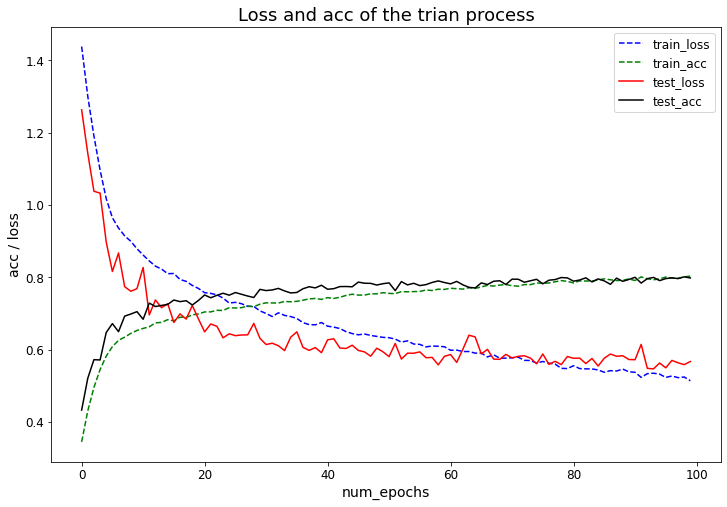

In [12]:
import matplotlib.pyplot as plt
# 设置全局图表大小
plt.rc('figure', figsize=(12, 8))
plt.rc('axes', titlesize=18)  # 设置轴标题的字体大小
plt.rc('axes', labelsize=14)  # 设置轴标签的字体大小
plt.rc('xtick', labelsize=12)  # 设置x轴刻度标签的字体大小
plt.rc('ytick', labelsize=12)  # 设置y轴刻度标签的字体大小
plt.rc('legend', fontsize=12)  # 设置图例的字体大小


plt.figure()
plt.title('Loss and acc of the trian process')
plt.plot(range(num_epochs), train_losses, 'b--', label='train_loss')
plt.plot(range(num_epochs), [x / 100 for x in train_accuracies], 'g--', label = 'train_acc')
plt.plot(range(num_epochs), test_losses, 'r', label = 'test_loss')
plt.plot(range(num_epochs), [x / 100 for x in test_accuracies], 'black', label = 'test_acc')
plt.xlabel('num_epochs')
plt.ylabel('acc / loss')
plt.legend(loc='best')
plt.show()

In [25]:

X = t.from_numpy(np.random.uniform(size=(1, 1, 48, 48))).float()
dcnn = DCNN(1, 5)
dcnn.eval()
X = dcnn(X)


Shape after conv1: torch.Size([1, 256, 48, 48])
Shape after conv2: torch.Size([1, 128, 48, 48])
Shape after pool1: torch.Size([1, 128, 24, 24])
Shape after conv3: torch.Size([1, 128, 24, 24])
Shape after conv4: torch.Size([1, 128, 24, 24])
Shape after pool2: torch.Size([1, 128, 12, 12])
Shape after conv5: torch.Size([1, 256, 12, 12])
Shape after conv6: torch.Size([1, 256, 12, 12])
Shape after pool3: torch.Size([1, 256, 6, 6])
Shape after flatten: torch.Size([1, 9216])
Shape after dense1: torch.Size([1, 128])
Shape after dropout4: torch.Size([1, 128])
Shape after out_layer: torch.Size([1, 5])
